# Playing with seismic data (INTERACTIVE)

Proof of concept to show how to setup simple way to interactively scroll through 3D (seismic) cubes.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import segyio
import xarray as xr

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## training images

(from <http://www.trainingimages.org/training-images-library.html>)

Maules Creek 3D SGEMS dataset (3D grid representing the hydrofacies in an alluvial aquifer in the Maules Creek valley, Australia):

In [2]:
rawdata = np.loadtxt(path+'Maules_Creek_3D.SGEMS.bz2', skiprows=3)
mauls = xr.DataArray(rawdata.reshape(80, 200, 340), dims=['Z','Y','X'])

NameError: name 'path' is not defined

West Coast of Africa object-based training images:

In [8]:
rawdata1 = np.loadtxt(path+'TI1.SGEMS.bz2', skiprows=3)
rawdata2 = np.loadtxt(path+'TI2.SGEMS.bz2', skiprows=3)
rawdata3 = np.loadtxt(path+'TI3.SGEMS.bz2', skiprows=3)
ti1 = xr.DataArray(rawdata1.reshape(116, 59, 78), dims=['Z','Y','X'])
ti2 = xr.DataArray(rawdata2.reshape(116, 59, 78), dims=['Z','Y','X'])
ti3 = xr.DataArray(rawdata3.reshape(116, 59, 78), dims=['Z','Y','X'])

Let's make a function to plot seismic data (I'll show later on a quicker way to make plots):

In [17]:
def plot_3_faces(cube,x,y,z):
    opt = {'add_colorbar': False}
    f, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
    cube.sel(X=x).plot(x='Y', y='Z', ax=ax[0], **opt)
    cube.sel(Y=y).plot(x='X', y='Z', ax=ax[1], **opt)
    cube.sel(Z=z).plot(x='X', y='Y', ax=ax[2], **opt)
    plt.tight_layout()

In [21]:
def plot_slice(cube,z):
    nlev = np.size(np.unique(cube.data))
    opt = {'add_colorbar': True, 'robust': True, 'levels': nlev}   
    f, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))
    cube.sel(Z=z).plot(x='X', y='Y', ax=ax, **opt)
    plt.tight_layout()

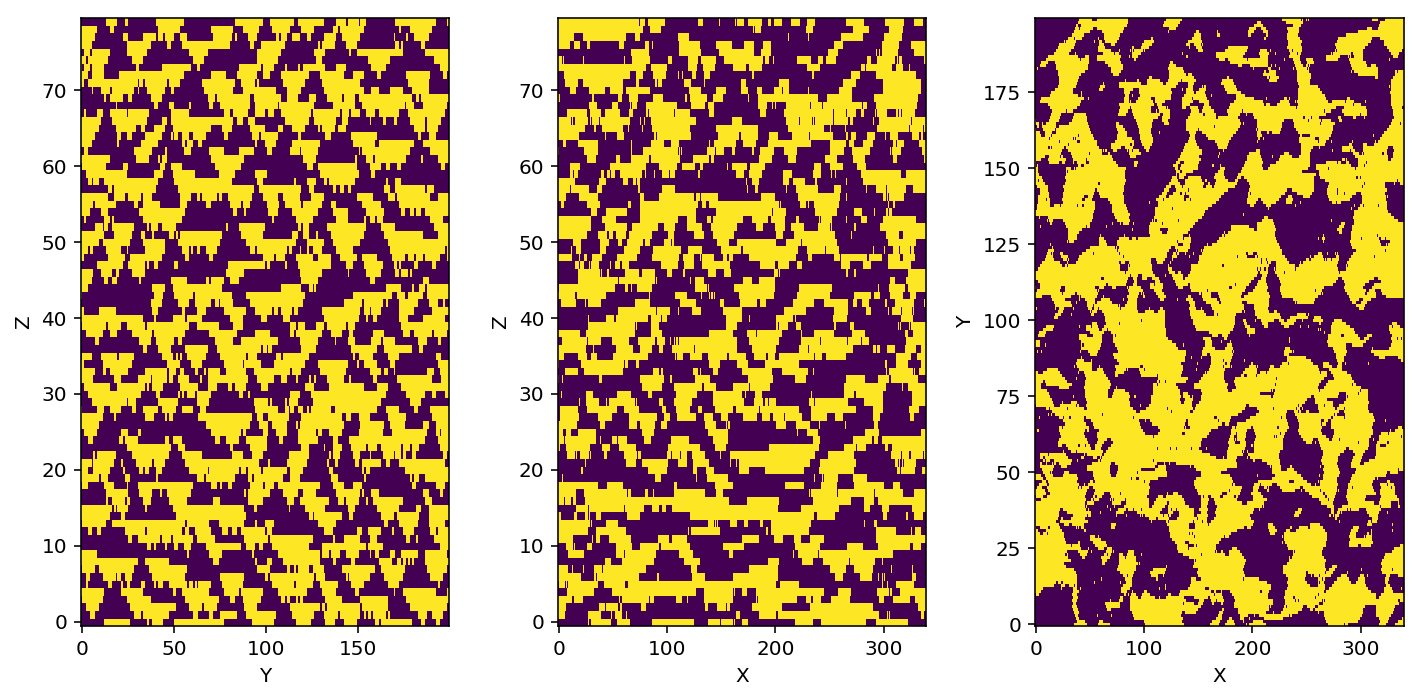

In [22]:
plot_3_faces(mauls,50,50,10)

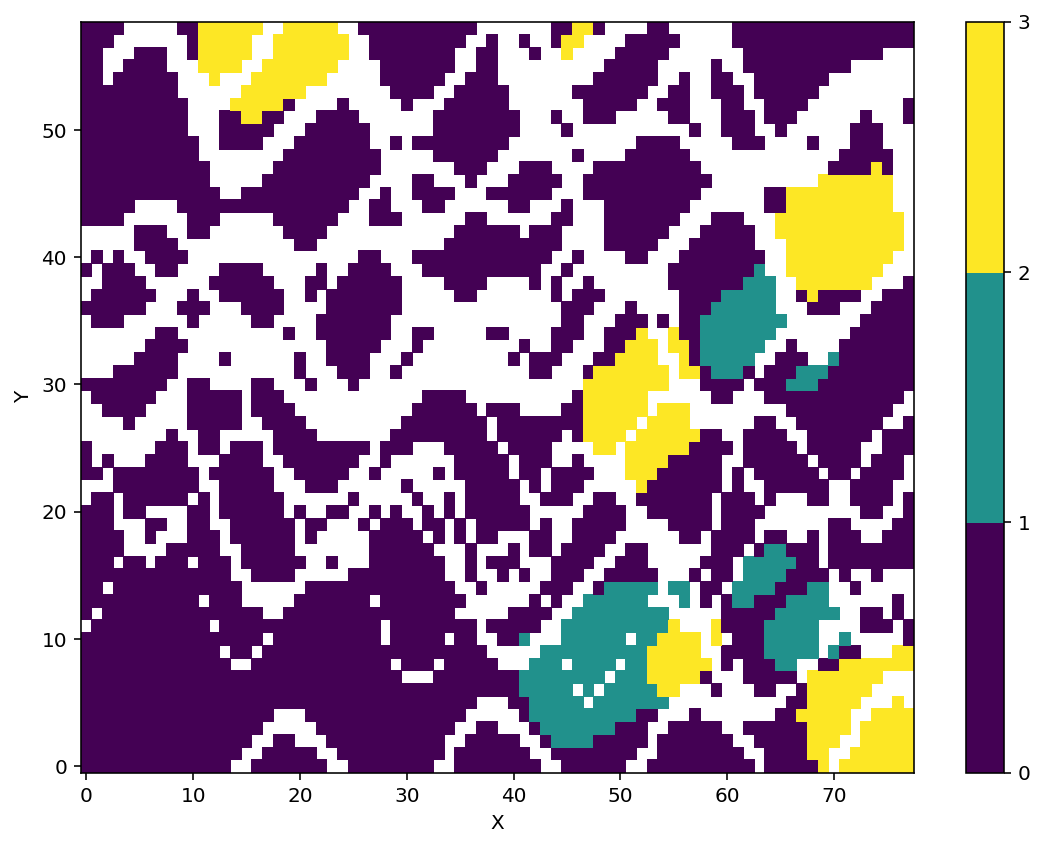

In [27]:
plot_slice(ti3,14)

In [33]:
w=interact_manual(plot_3_faces(mauls,x,y,z),
                  x=(1,100),
                  y=(1,100),
                  z=(1,100))

NameError: name 'x' is not defined

In [ ]:
opt1 = {'add_colorbar': True, 'robust': True}
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
mauls_near.sel(X=150).plot(x='Y', y='Z', ax=ax[0], **opt1)
mauls_near.sel(Y=100).plot(x='X', y='Z', ax=ax[1], **opt1)
mauls_near.sel(Z=30).plot(x='X', y='Y', ax=ax[2], **opt1)
plt.tight_layout()

In the function above you can also choose your preferred colormaps (it defaults to the classic red-blue seismic map). The default is the classical red-white-blue (`seismic`), other nice colormaps are `Greys`, `coolwarm`, `RdGy` (and don't forget to read these  essays on colormaps by [Matteo](http://nbviewer.ipython.org/github/mycarta/tutorials/blob/master/1408_Evaluate_and_compare_colormaps/How_to_evaluate_and_compare_colormaps.ipynb) and [Jake]( https://jakevdp.github.io/blog/2014/10/16/how-bad-is-your-colormap/
)).

All the colormaps available in [matplotlib](http://matplotlib.org/) are listed here:

* http://matplotlib.org/examples/color/colormaps_reference.html
* http://wiki.scipy.org/Cookbook/Matplotlib/Show_colormaps 

For example, let's plot the same line between 0.5 and 1.5 seconds of data using a different colormap:

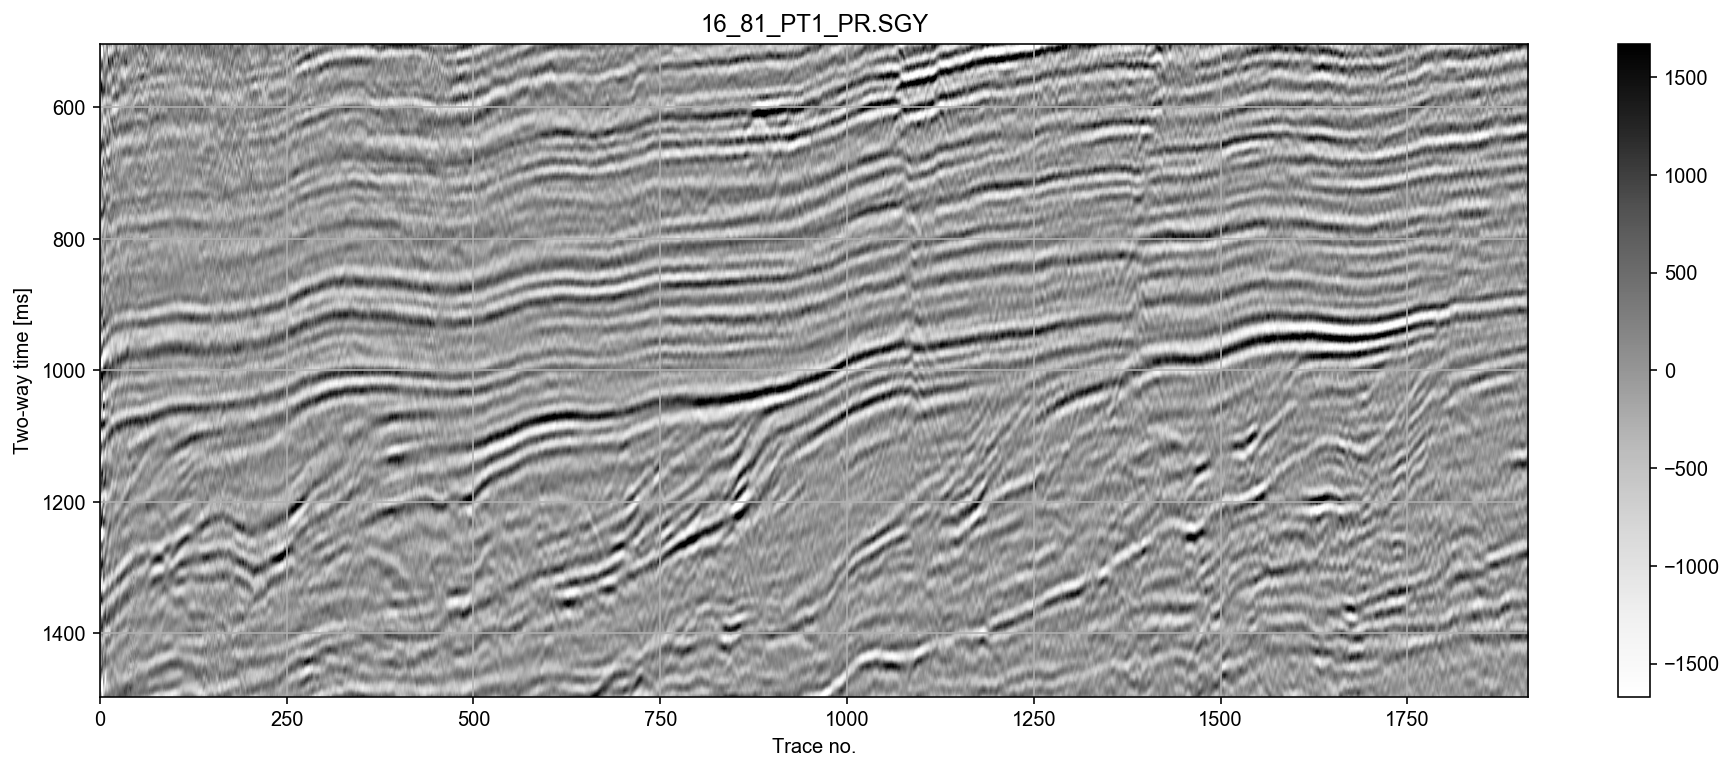

In [8]:
dd = (twt>500) & (twt<1500)
plot_seismic(data[dd,:],twt[dd],filename,colr='Greys',clip_val=clip)

### comparison displays

Just for fun, let's build another two copies of the line above, we'll change them a bit and compare to one another.

The first one will be a noisy version of dhe data above, the second will be smoother instead (code for adding noise and smoothing the data taken straight from [this notebook by Matt Hall](http://nbviewer.ipython.org/github/agile-geoscience/notebooks/blob/master/Filtering_horizons.ipynb):

In [9]:
t1, t2 = 1000, 1500
line_zoom = data[(twt>=t1) & (twt<=t2),:]
noise = np.random.uniform(-1500,1500, line_zoom.shape)
line_noise = line_zoom + noise

import scipy.signal
kernel = np.ones((5,5)) / 25
line_filt = scipy.signal.convolve2d(line_zoom, kernel)

This is the code to display the 3 lines together:

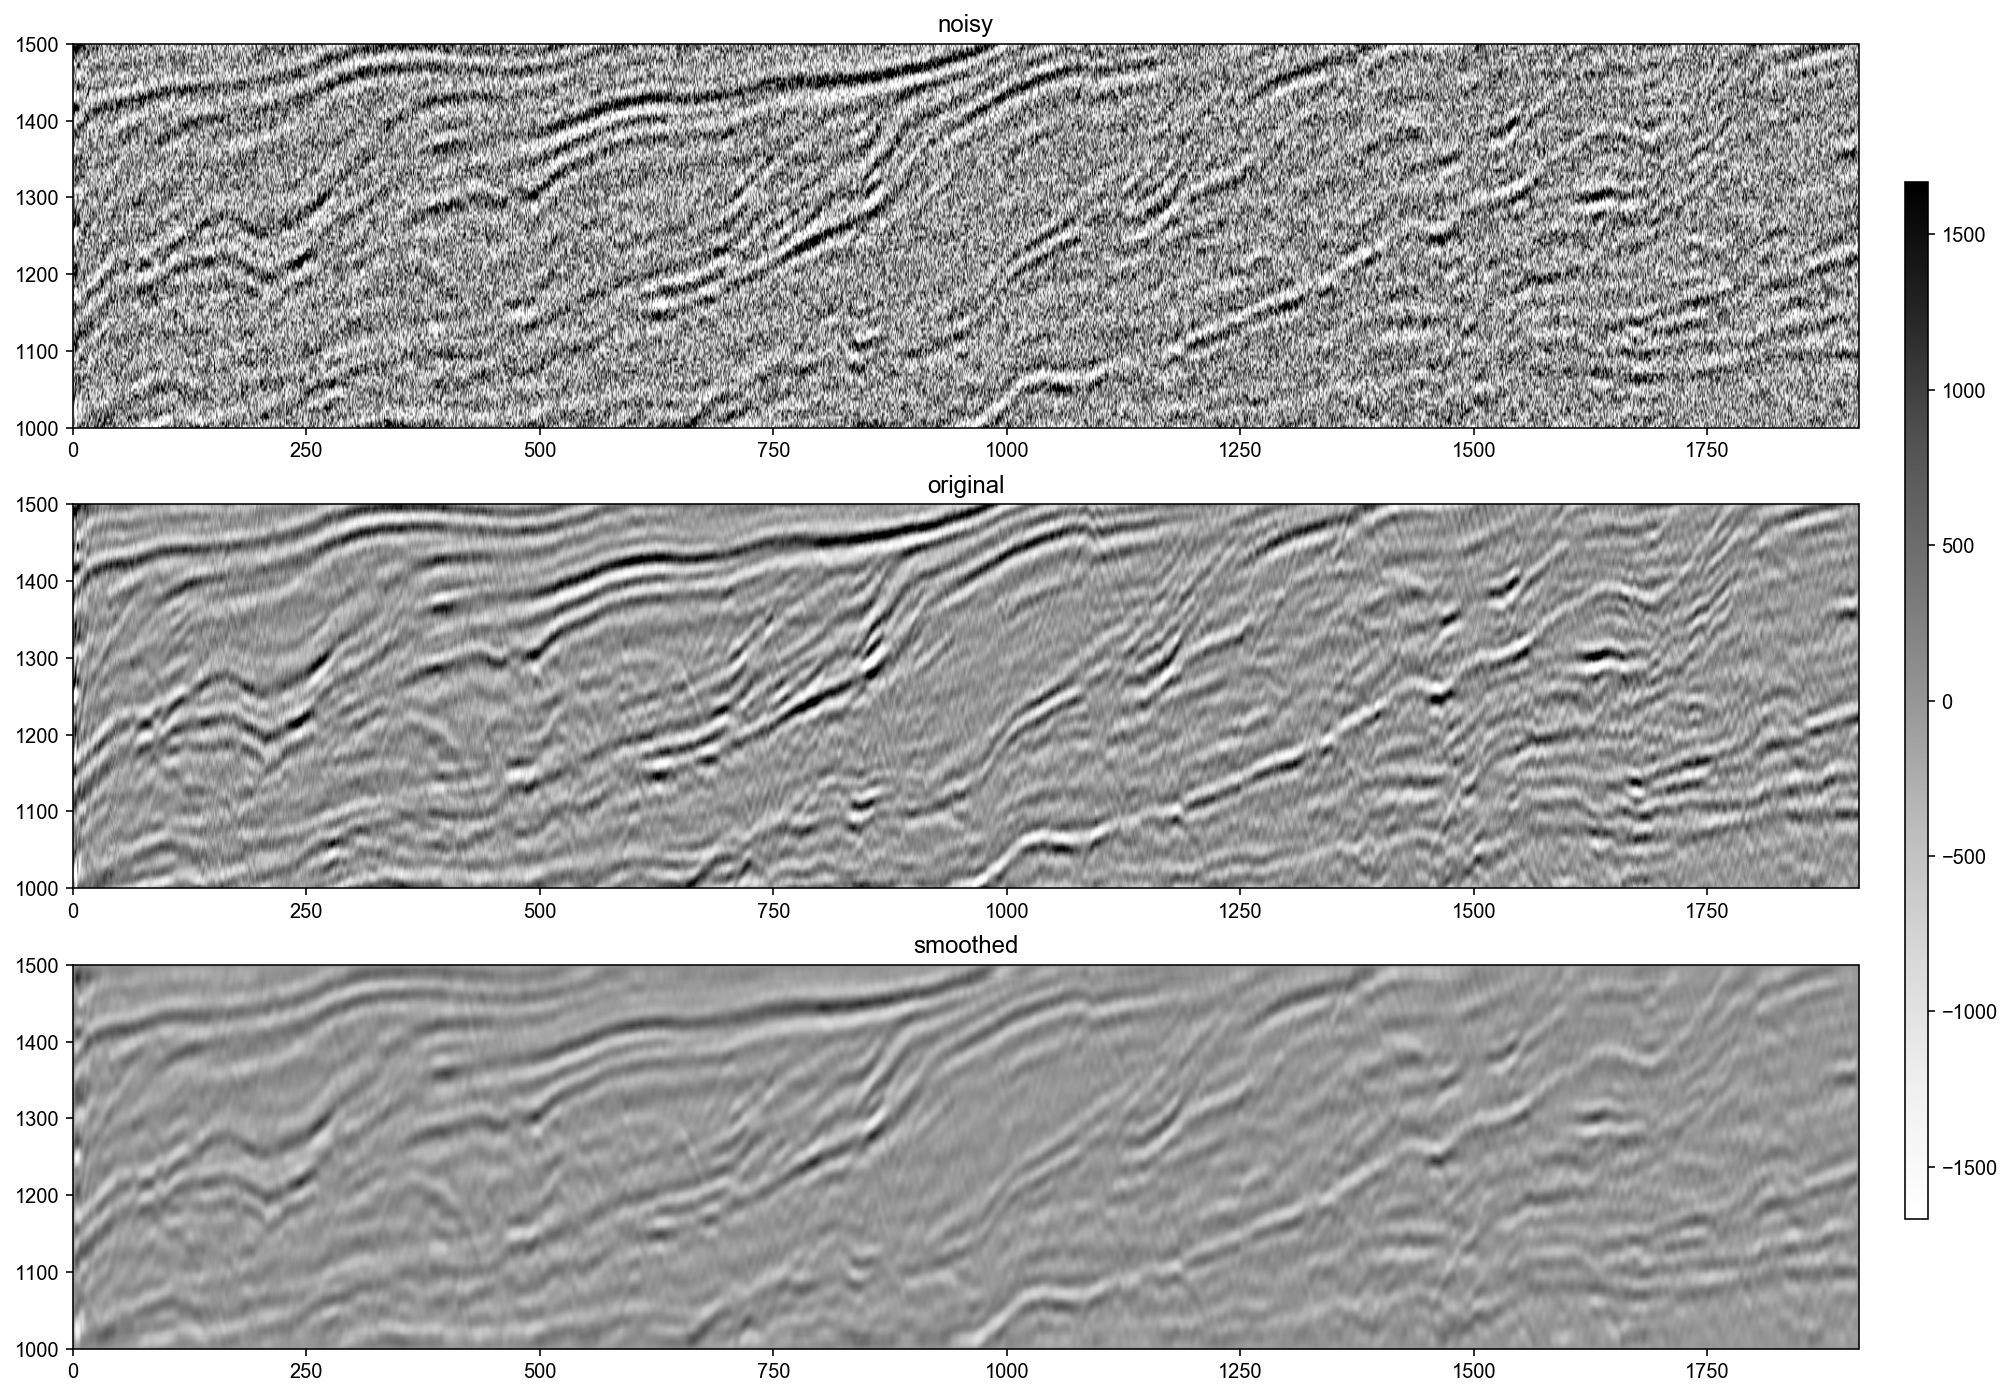

In [10]:
f, ax = plt.subplots(nrows=3,ncols=1,figsize=(16,12),facecolor='w')
im0=ax[0].imshow(line_noise,interpolation='bilinear',aspect='auto',cmap='Greys',extent=(0,ntraces,t1,t2),vmin=-clip,vmax=clip)
im1=ax[1].imshow(line_zoom, interpolation='bilinear',aspect='auto',cmap='Greys',extent=(0,ntraces,t1,t2),vmin=-clip,vmax=clip)
im2=ax[2].imshow(line_filt, interpolation='bilinear',aspect='auto',cmap='Greys',extent=(0,ntraces,t1,t2),vmin=-clip,vmax=clip)
ax[0].set_title('noisy'), ax[1].set_title('original'), ax[2].set_title('smoothed')
cax = f.add_axes([0.92, 0.2, 0.01, 0.6])
f.colorbar(im0, cax=cax, orientation='vertical')

## functions to do it all and quickly

This is a function to read a SEG-Y and output a Numpy array together with all the relevant information:

In [2]:
def read_segy(f, lag=0, twod=False, byte_il=189, byte_xl=193):
    '''
    read_segy (C) aadm 2018 // using Statoil's segyio
    '''
    if twod:
        with segyio.open(filename, 'r', ignore_geometry=True) as segyfile:
            sr = segyio.tools.dt(segyfile)/1e3
            nsamples = segyfile.samples.size
            twt = segyfile.samples
            ntraces = segyfile.tracecount
            data = segyfile.trace.raw[:]
            header = segyio.tools.wrap(segyfile.text[0])      
    else:
        with segyio.open(f, iline=byte_il, xline=byte_xl) as segyfile:
            sr = segyio.tools.dt(segyfile)/1e3
            nsamples = segyfile.samples.size
            twt = segyfile.samples
            ntraces = segyfile.tracecount
            data = segyio.tools.cube(segyfile)
            header = segyio.tools.wrap(segyfile.text[0])  
            inlines = segyfile.ilines
            crosslines = segyfile.xlines
    size_mb= data.nbytes/1024**2
    print('[read_segy] number of traces: {0}, samples: {1}, sample rate: {2} s'.format(ntraces,nsamples,sr))
    print('[read_segy] first, last sample twt: {0}, {1} s'.format(twt[0],twt[-1]))
    print('[read_segy] size: {:.2f} Mb ({:.2f} Gb)'.format(size_mb, size_mb/1024))
    if not twod:
        print('[read_segy] inlines: {:.0f}, min={:.0f}, max={:.0f}'.format(inlines.size,inlines.min(),inlines.max()))
        print('[read_segy] crosslines: {:.0f}, min={:.0f}, max={:.0f}'.format(crosslines.size,crosslines.min(),crosslines.max()))
        return data, nsamples, sr, twt, ntraces, header, inlines, crosslines
    else:
        return data, nsamples, sr, twt, ntraces, header

I will use the above function to load also the far-stack volume (which shares same geometry as the near-stack so I will discard all other outputs of the `read_segy` function, i.e. number of samples, traces, etc.):

In [3]:
read_segy('3d_farstack.sgy',byte_il=41,byte_xl=21)

[read_segy] number of traces: 25351, samples: 250, sample rate: 4.0 s
[read_segy] first, last sample twt: 0.0, 996.0 s
[read_segy] size: 24.18 Mb (0.02 Gb)
[read_segy] inlines: 101, min=1300000, max=1500000
[read_segy] crosslines: 251, min=1500, max=2000


(array([[[  -97., -1197., -1473., ...,   736.,   454.,   102.],
         [ -235.,  -714., -1326., ...,  1095.,  1397.,   706.],
         [ 1263.,  -501., -2641., ...,  1585.,   942.,  -127.],
         ...,
         [  962.,  -735., -2468., ..., -1360.,   718.,  2232.],
         [ 1294.,  -934., -2622., ...,  -833.,   812.,  1129.],
         [ 1511.,  -336., -2407., ...,  -211.,  1104.,   863.]],
 
        [[ 1342.,   390., -1646., ...,  -264.,    -4.,   515.],
         [ 2617.,  2110., -1703., ...,   570.,   846.,   371.],
         [ 1843.,  1770., -1109., ...,   570.,   496.,   -58.],
         ...,
         [  772.,  -320., -2268., ...,  -849.,   894.,  2681.],
         [  520.,  -718., -1898., ...,   112.,  1240.,  1599.],
         [  605., -1644., -2281., ...,   561.,  1164.,  1471.]],
 
        [[  768.,   652., -1209., ...,   718.,   801.,   307.],
         [ 1633.,  2244.,  -727., ...,   737.,   237.,  -435.],
         [ 1429.,  1420.,  -969., ...,   -47.,   242.,   298.],
      

In [4]:
data, nsamples, sr, twt, ntraces, header, inlines, crosslines = read_segy('3d_farstack.sgy',byte_il=41,byte_xl=21)
far = xr.DataArray(data,[('IL',inlines/ 1000),('XL',crosslines),('TWT',twt + 1500)])

data, nsamples, sr, twt, ntraces, header, inlines, crosslines = read_segy('3d_nearstack.sgy',byte_il=41,byte_xl=21)
near = xr.DataArray(data,[('IL',inlines/ 1000),('XL',crosslines),('TWT',twt + 1500)])

[read_segy] number of traces: 25351, samples: 250, sample rate: 4.0 s
[read_segy] first, last sample twt: 0.0, 996.0 s
[read_segy] size: 24.18 Mb (0.02 Gb)
[read_segy] inlines: 101, min=1300000, max=1500000
[read_segy] crosslines: 251, min=1500, max=2000
[read_segy] number of traces: 25351, samples: 250, sample rate: 4.0 s
[read_segy] first, last sample twt: 0.0, 996.0 s
[read_segy] size: 24.18 Mb (0.02 Gb)
[read_segy] inlines: 101, min=1300000, max=1500000
[read_segy] crosslines: 251, min=1500, max=2000


I will now select one inline from Near and Far volumes then calculate AVO Intercept and Gradient using a simple Shuey 2-term approach (see also my other notes on [AVO attributes](http://nbviewer.ipython.org/github/aadm/geophysical_notes/blob/master/avo_attributes.ipynb)):

In [5]:
near_il

NameError: name 'near_il' is not defined

In [6]:
near_il = near.sel(IL=1376)
far_il = far.sel(IL=1376)

An=np.sin(np.radians(5))**2
Af=np.sin(np.radians(30))**2
G = (far_il - near_il)/(Af-An)
I = near_il - G*An

Display the Intercept and Gradient inline and crossplot the two attributes:

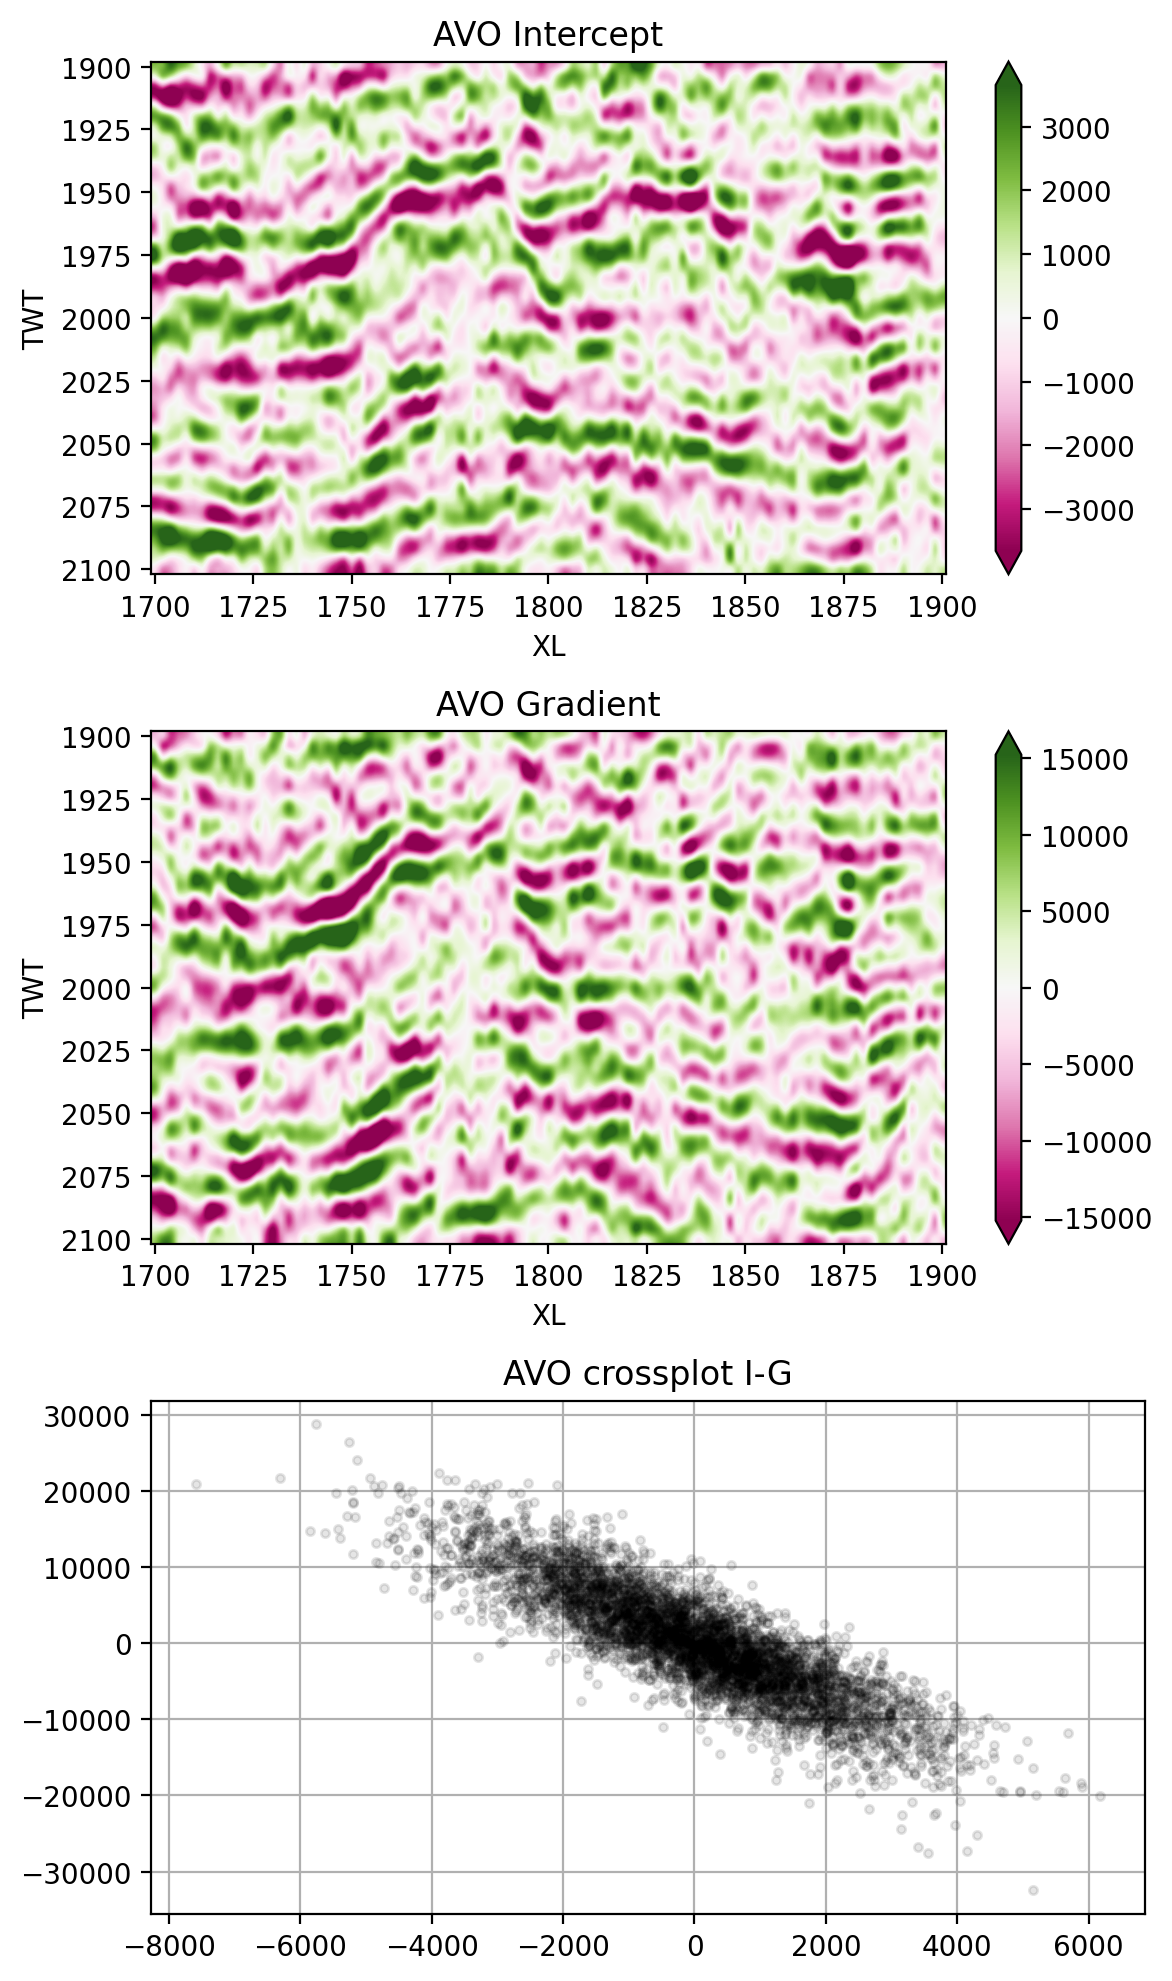

In [7]:
Izoom=I.sel(TWT=slice(1900,2100),XL=slice(1700,1900))
Gzoom=G.sel(TWT=slice(1900,2100),XL=slice(1700,1900))

uu={'add_colorbar':True,'robust':True,'interpolation':'spline16','cmap':'PiYG'}

f, ax = plt.subplots(nrows=3,ncols=1,figsize=(6,10))
Izoom.plot.imshow(x='XL',y='TWT',yincrease=False,ax=ax[0],**uu)
Gzoom.plot.imshow(x='XL',y='TWT',yincrease=False,ax=ax[1],**uu)
ax[2].plot(Izoom,Gzoom,'.k',alpha=0.1)
ax[0].set_title('AVO Intercept')
ax[1].set_title('AVO Gradient')
ax[2].set_title('AVO crossplot I-G')
ax[2].grid()
plt.tight_layout()

In [8]:
def ampspec(signal,sr,smooth=False):
    '''
    ampspec (C) aadm 2016
    Calculates amplitude spectrum of a signal with FFT optionally smoothed via cubic interpolation.

    INPUT
    signal: 1D numpy array
    sr: sample rate in ms
    smooth: True or False

    OUTPUT
    freq: frequency
    amp: amplitude
    '''

    SIGNAL = np.fft.fft(signal)
    freq = np.fft.fftfreq(signal.size, d=sr*0.001)
    keep = freq>=0
    SIGNAL = np.abs(SIGNAL[keep])
    freq = freq[keep]
    if smooth:
        freq0=np.linspace(freq.min(),freq.max()/2,freq.size*10)
        f = interp1d(freq, SIGNAL, kind='cubic')
        return freq0, f(freq0)
    else:
        return freq, SIGNAL

def fullspec(data,sr):
    '''
    fullspec (C) aadm 2016-2018
    Calculates amplitude spectrum of 2D numpy array.

    INPUT
    data: 2D numpy array, shape=(traces, samples)
    sr: sample rate in ms

    OUTPUT
    freq: frequency
    amp: amplitude
    db: amplitude in dB scale
    f_peak: average peak frequency
    '''
    amps, peaks = [], []
    for i in range(data.shape[0]):
        trace = data[i,:]
        freq, amp = ampspec(trace,sr)
        peak = freq[np.argmax(amp)]
        amps.append(amp)
        peaks.append(peak)
    amp0 = np.mean(np.dstack(amps), axis=-1)
    amp0 = np.squeeze(amp0)
    db0 = 20 * np.log10(amp0)
    db0 = db0 - np.amax(db0)
    f_peak = np.mean(peaks)
    print('freq peak: {:.2f} Hz'.format(f_peak))
    return freq,amp0,db0,f_peak

def plot_ampspec(freq,amp,f_peak,name=None):
    '''
    plot_ampspec (C) aadm 2016-2018
    Plots amplitude spectrum calculated with fullspec (aageofisica.py).

    INPUT
    freq: frequency
    amp: amplitude
    f_peak: average peak frequency
    '''
    db = 20 * np.log10(amp)
    db = db - np.amax(db)
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,5),facecolor='w')
    ax[0].plot(freq, amp, '-k', lw=2)
    ax[0].set_ylabel('Power')
    ax[1].plot(freq, db, '-k', lw=2)
    ax[1].set_ylabel('Power (dB)')
    for aa in ax:
        aa.set_xlabel('Frequency (Hz)')
        aa.set_xlim([0,np.amax(freq)/1.5])
        aa.grid()
        aa.axvline(f_peak, color='r', ls='-')
        if name!=None:
            aa.set_title(name, fontsize=16)

def plot_ampspec2(freq1,amp1,f_peak1,freq2,amp2,f_peak2,name1=None,name2=None):
    '''
    plot_ampspec2 (C) aadm 2016-2018
    Plots overlay of 2 amplitude spectra calculated with fullspec.

    INPUT
    freq1, freq2: frequency
    amp1, amp2: amplitude spectra
    f_peak1, f_peak2: average peak frequency
    '''
    db1 = 20 * np.log10(amp1)
    db1 = db1 - np.amax(db1)
    db2 = 20 * np.log10(amp2)
    db2 = db2 - np.amax(db2)
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,5),facecolor='w')
    if name1 is not None:
        label1='{:s} Fp={:.0f} Hz'.format(name1,f_peak1)
        label2='{:s} Fp={:.0f} Hz'.format(name2,f_peak2)
    else:
        label1='Fp={:.0f} Hz'.format(f_peak1)
        label2='Fp={:.0f} Hz'.format(f_peak2)
    ax[0].plot(freq1, amp1, '-k', lw=2, label=label1)
    ax[0].plot(freq2, amp2, '-r', lw=2, label=label2)
    ax[0].fill_between(freq1,0,amp1,lw=0, facecolor='k',alpha=0.25)
    ax[0].fill_between(freq2,0,amp2,lw=0, facecolor='r',alpha=0.25)
    ax[0].set_ylabel('Power')
    ax[1].plot(freq1, db1, '-k', lw=2, label=label1)
    ax[1].plot(freq2, db2, '-r', lw=2,label=label2)
    lower_limit=np.min(ax[1].get_ylim())
    ax[1].fill_between(freq1, db1, lower_limit, lw=0, facecolor='k', alpha=0.25)
    ax[1].fill_between(freq2, db2, lower_limit, lw=0, facecolor='r', alpha=0.25)
    ax[1].set_ylabel('Power (dB)')
    for aa in ax:
        aa.set_xlabel('Frequency (Hz)')
        aa.set_xlim([0,np.amax(freq)/1.5])
        aa.grid()
        aa.axvline(f_peak1, color='k', ls='-')
        aa.axvline(f_peak2, color='r', ls='-')
        aa.legend(fontsize='small')

Let's read in again the 2D line using the `read_segy` function:

In [9]:
filename='16_81_PT1_PR.SGY'
data,  nsamples, sr, twt, ntraces, header = read_segy(filename, twod=True)
twod = xr.DataArray(data,[('TRACES',np.arange(ntraces)),('TWT',twt)])

[read_segy] number of traces: 1912, samples: 1501, sample rate: 4.0 s
[read_segy] first, last sample twt: 0.0, 6000.0 s
[read_segy] size: 10.95 Mb (0.01 Gb)


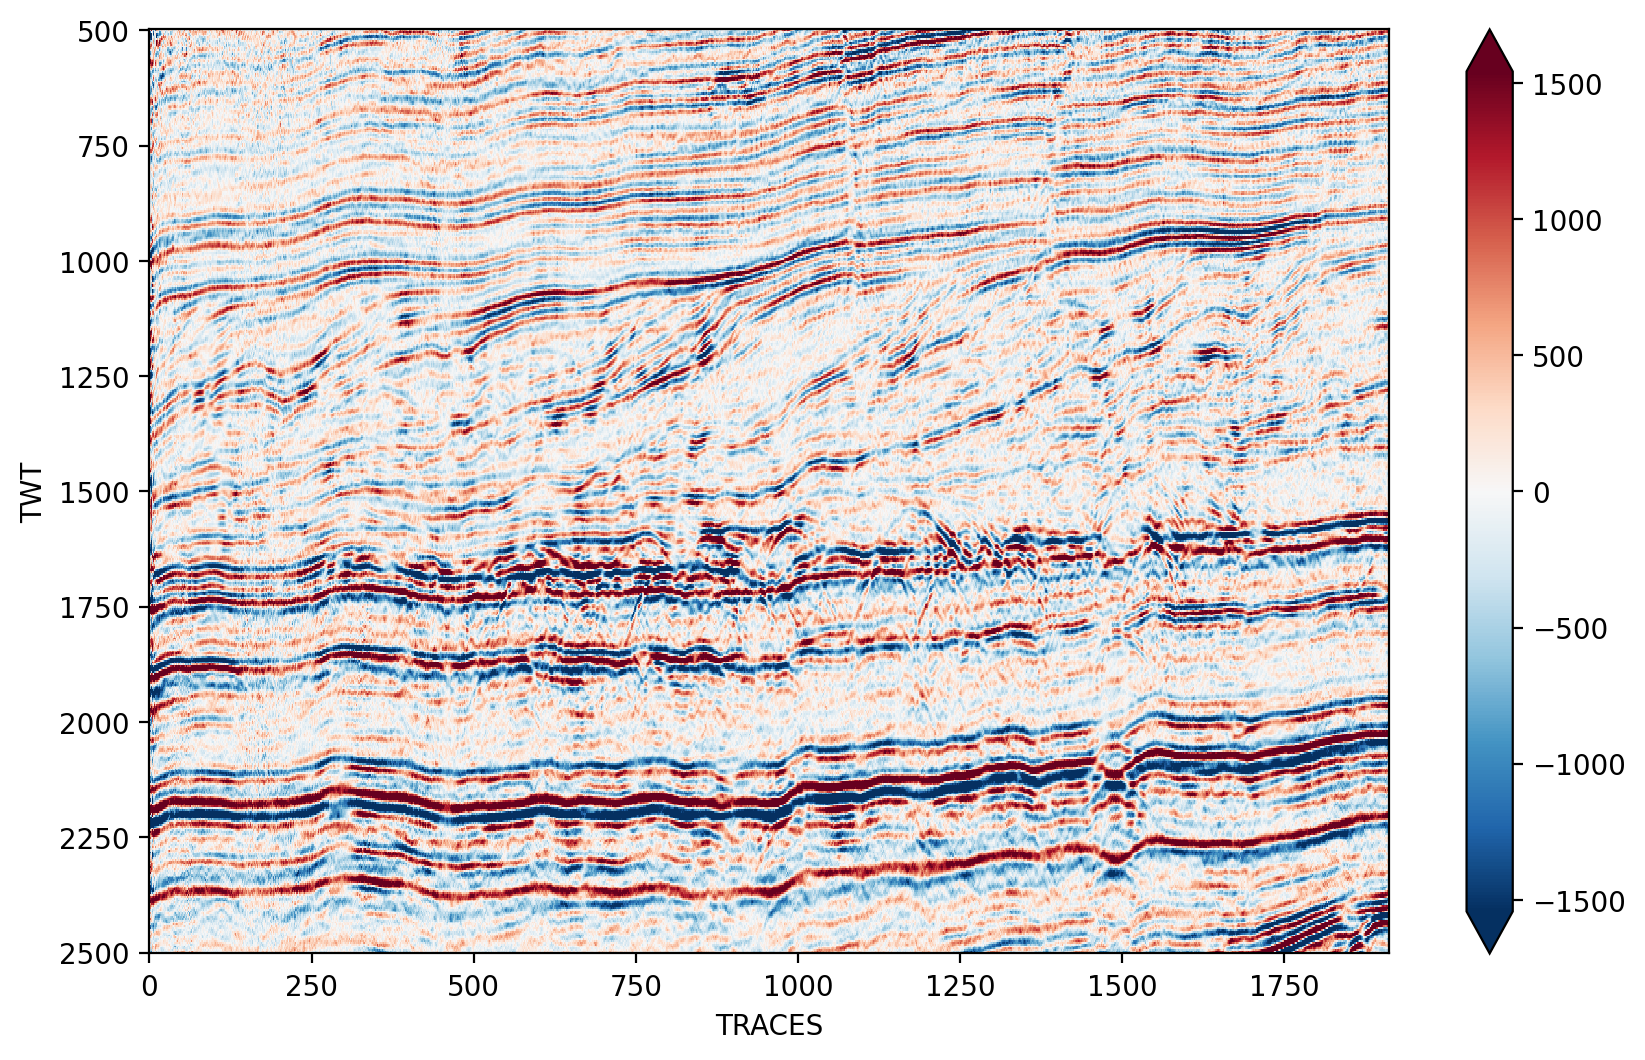

In [10]:
f,ax=plt.subplots(figsize=(10,6))
twod.sel(TWT=slice(500,2500)).plot.imshow(x='TRACES',y='TWT',robust=True,yincrease=False,ax=ax)

Here's how to use the `ampspec` function to compute the amplitude spectrum of one trace:

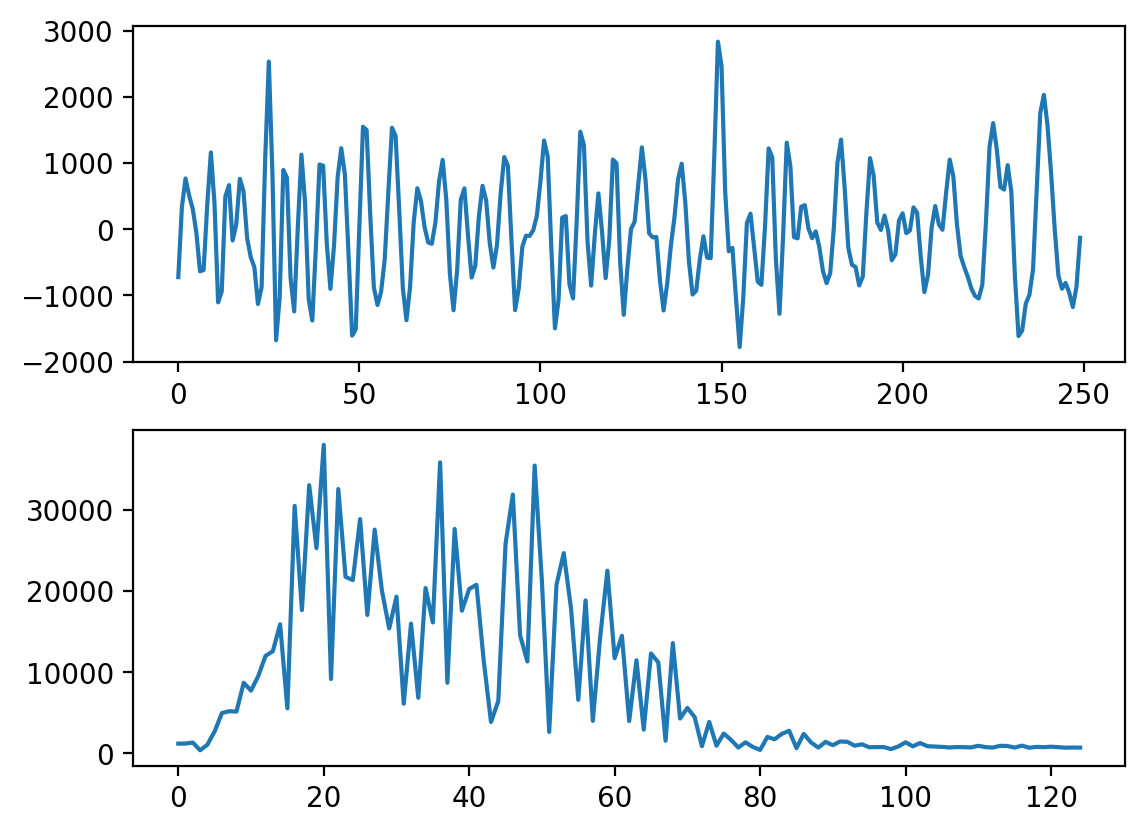

In [11]:
tr = far.sel(IL=1320, XL=1600).data
f,ax = plt.subplots(2)
ax[0].plot(tr)
ax[1].plot(ampspec(tr,sr)[1])

freq peak: 37.99 Hz
freq peak: 27.89 Hz


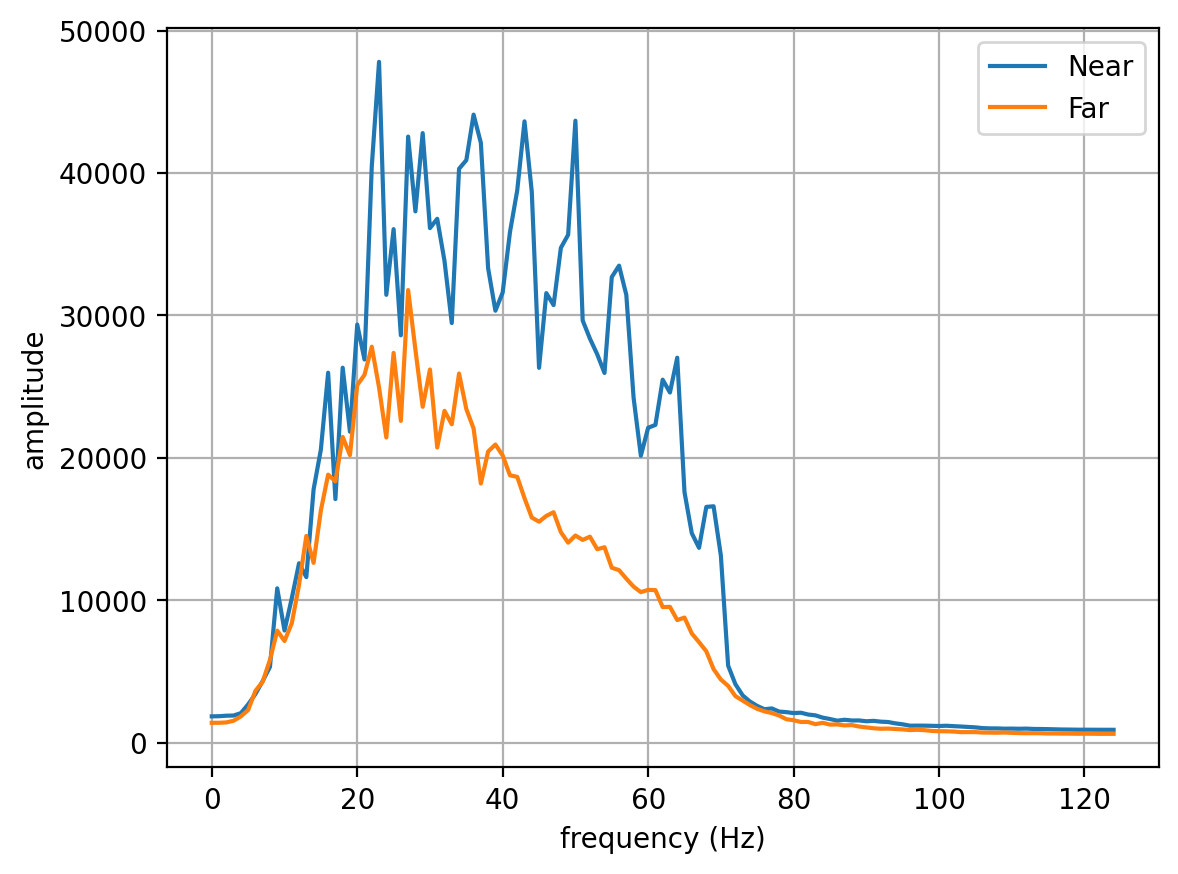

In [12]:
line_near = near.sel(IL=1320).data
line_far  = far.sel(IL=1320).data

f,ax = plt.subplots()
ax.plot(fullspec(line_near,sr)[1],label='Near')
ax.plot(fullspec(line_far,sr)[1],label='Far')
ax.set_ylabel('amplitude')
ax.set_xlabel('frequency (Hz)')
ax.grid()
ax.legend()

The function `plot_ampspec` plots the frequency spectrum in bot linear and dB scales, plus also draws a red marker corresponding to the peak frequency:

freq peak: 19.56 Hz


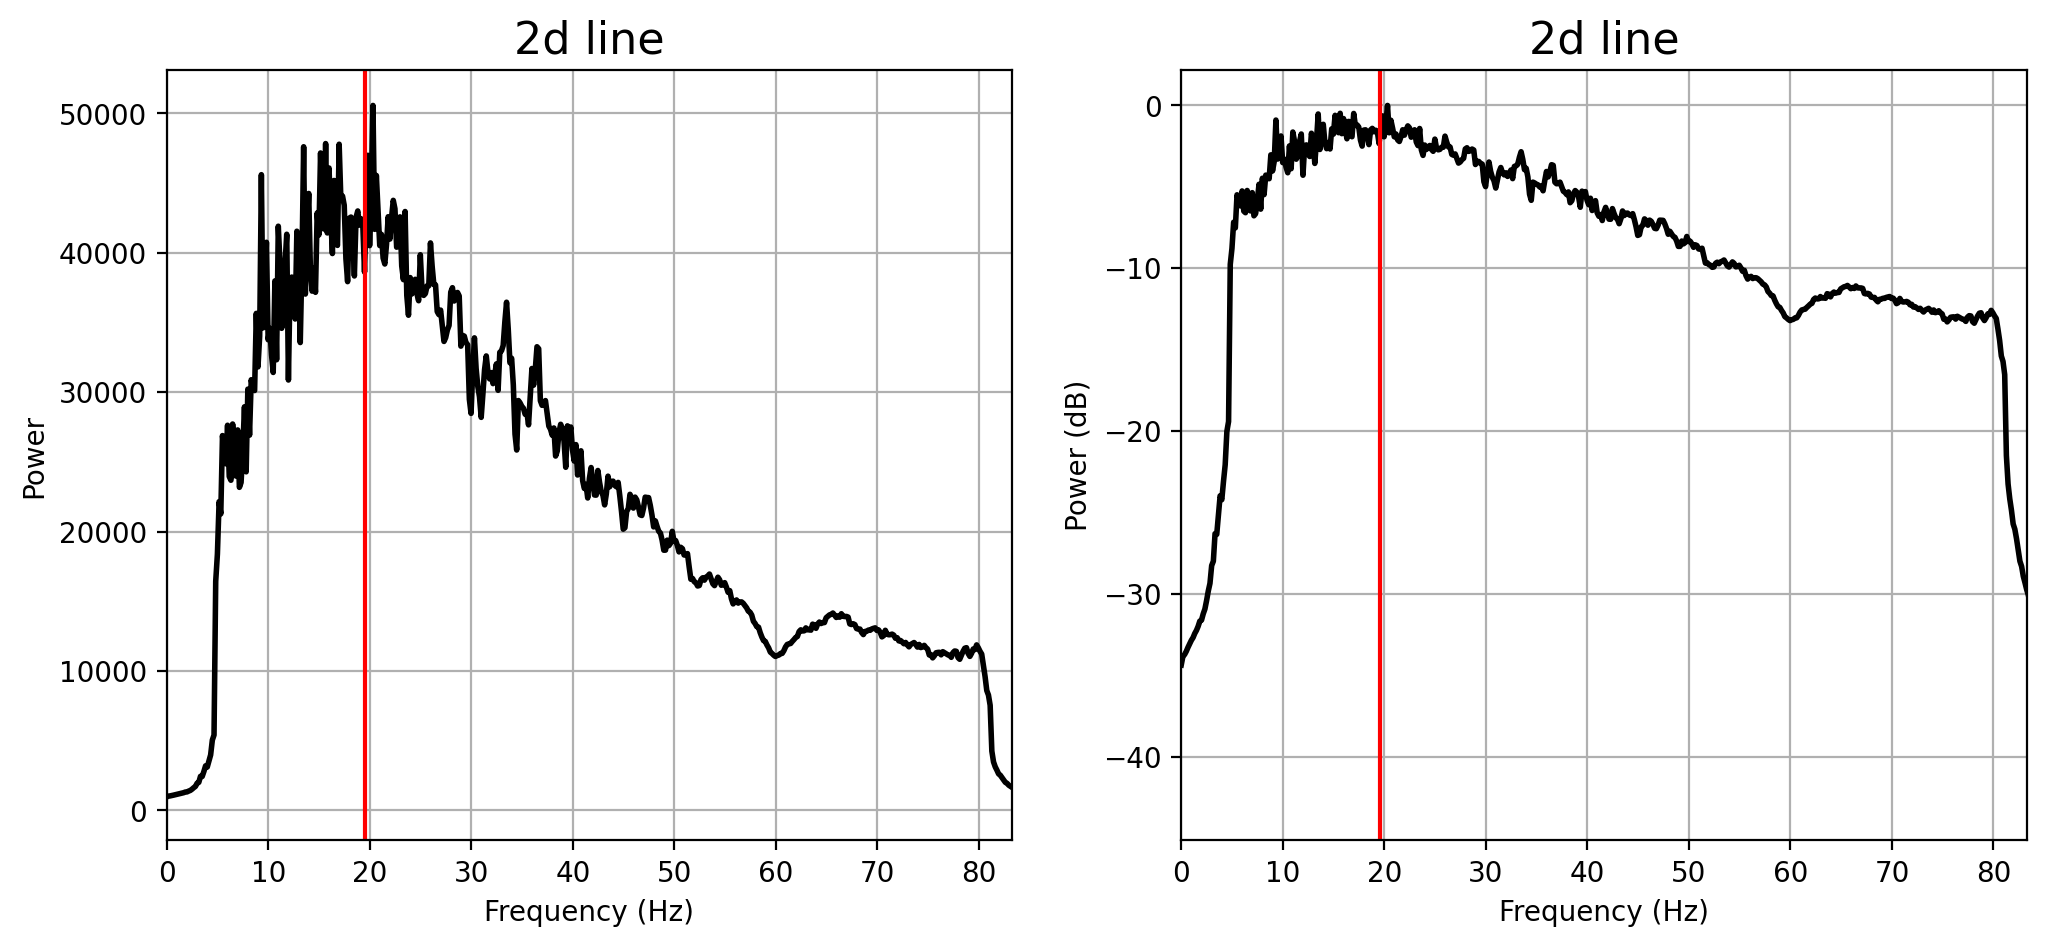

In [13]:
freq,amp,db,fpeak = fullspec(twod,sr)
plot_ampspec(freq,amp,fpeak,name='2d line')

Let's see how the amplitude spectrum differs in the first two seconds of data:

freq peak: 29.69 Hz


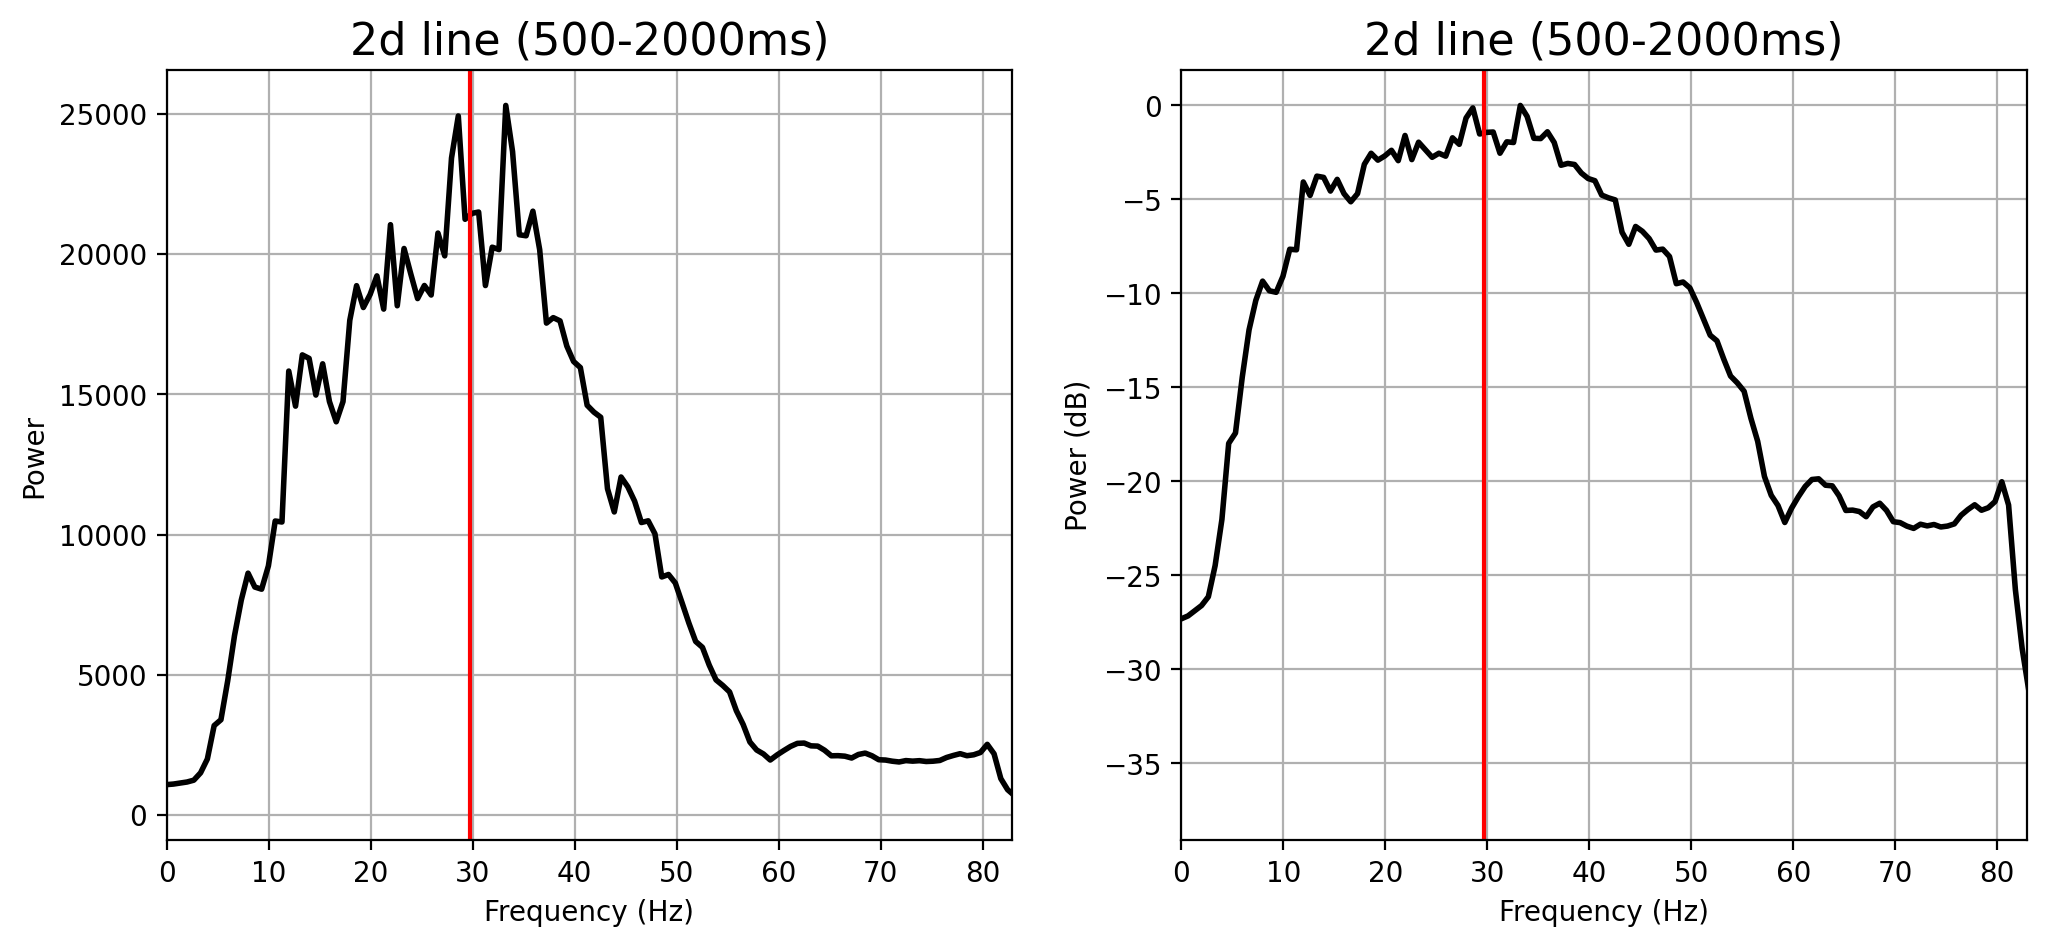

In [14]:
freq_shallow,amp_shallow,db_shallow,fpeak_shallow = fullspec(twod.sel(TWT=slice(500,2000)),sr)
plot_ampspec(freq_shallow,amp_shallow,fpeak_shallow,name='2d line (500-2000ms)')

The last function, `plot_ampspec2` simply plots two amplitude spectra on top of each other using the same layout as above:

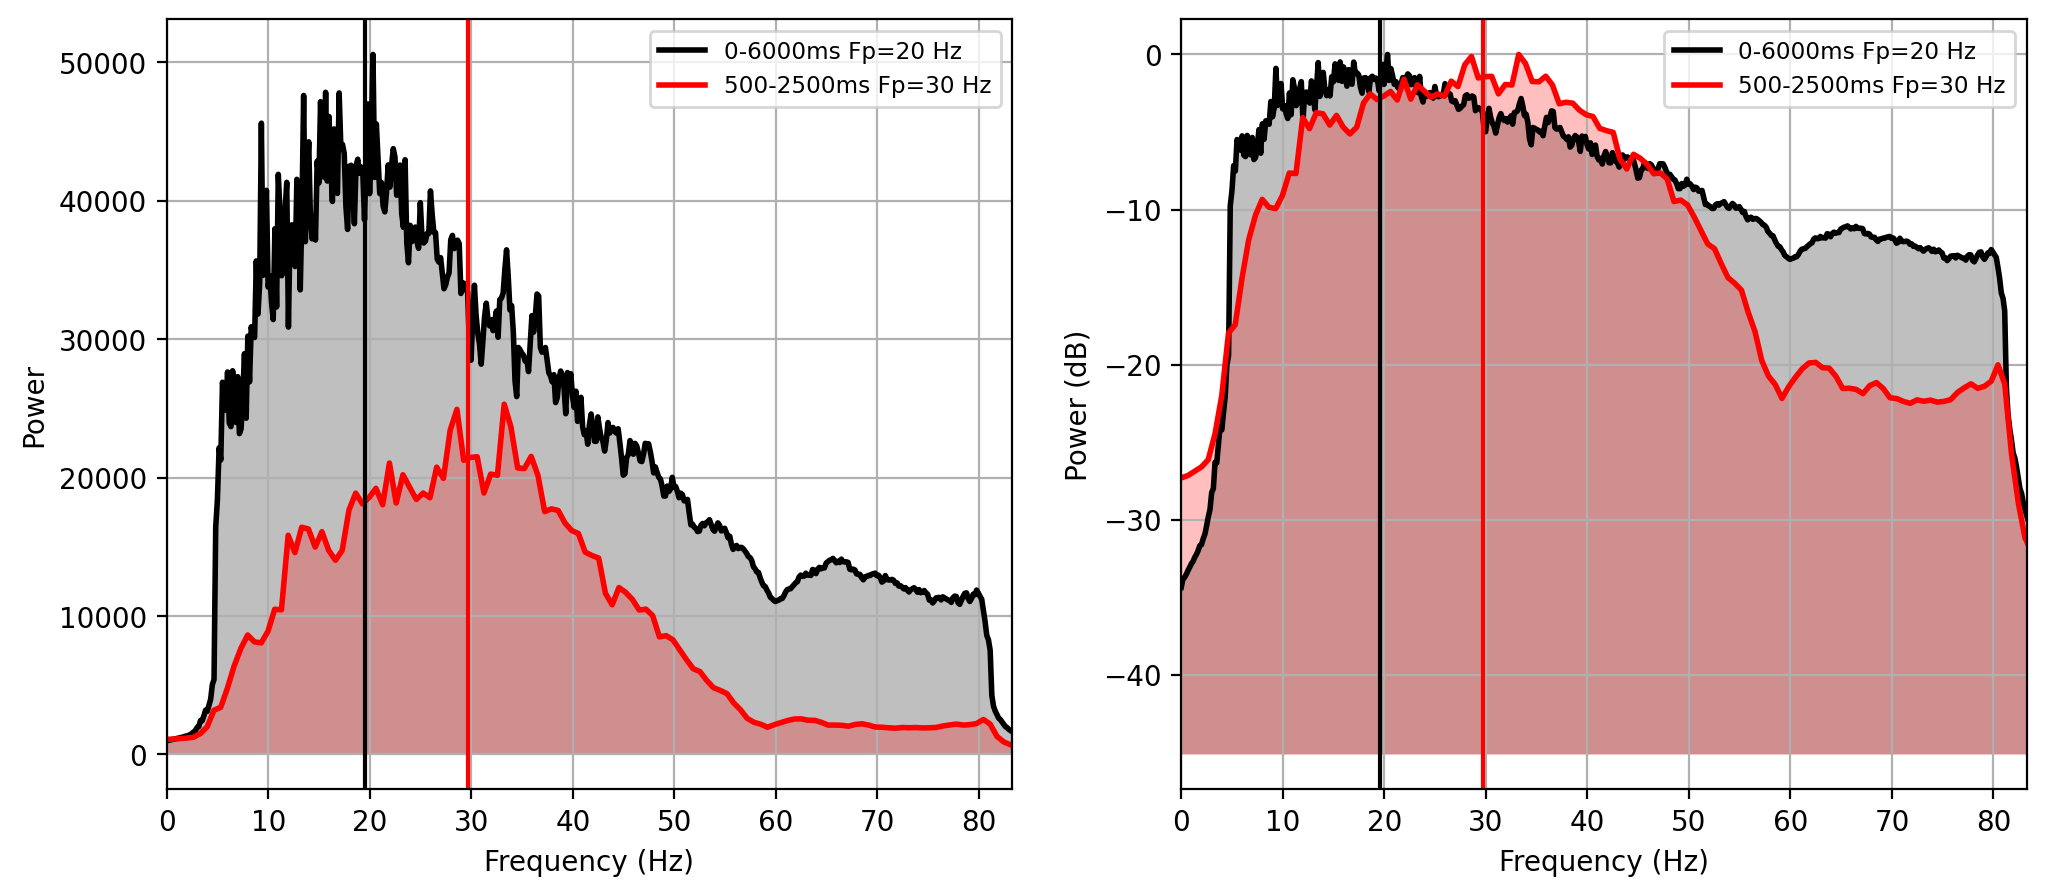

In [15]:
plot_ampspec2(freq,amp,fpeak,freq_shallow,amp_shallow,fpeak_shallow,name1='0-6000ms',name2='500-2500ms')